# 2 Programming problem [75 points]


For this problem, you will implement a video search method to retrieve relevant frames from a video
based on the features in a query region selected from some frame. We are providing image data and some
starter code for this assignment.

## Provided data

You can access pre–computed SIFT features here: https://filebox.ece.vt.edu/~F13ECE5554/resources/PS4_material/PS4SIFT.zip.

The associated images are stored here: https://filebox.ece.vt.edu/~F13ECE5554/resources/PS4_material/PS4Frames.zip.

Please note that the data takes about 6GB. Each .mat file in the provided SIFT data corresponds to a single
image, and contains the following variables, where `N` is the number of detected SIFT features in that image:

|   | shape | type | description |
|:-:|:-----:|:----:|:-----------:|
| descriptors | Nx128 | double | the SIFT vectors as rows |
| imname | 1x57 | char | name of the image file that goes with this data |
| numfeats | 1x1 | double | number of detected features |
| orients | Nx1 | double | the orientations of the patches |
| positions | Nx2 | double | the positions of the patch centers |
| scales | Nx1 | double | the scales of the patches |

## Provided code

The following are the provided code files. You are not required to use any of these functions, but you will
probably find them helpful.

**loadDataExample.py**: Run this code first and make sure you understand the data format. It is
a script that selects a random image, and shows how to access the descriptors. It also shows how to use
some of the other functions below.

**displaySIFTPatches.py**: given SIFT descriptor info, it returns the corners corresponding to each patch.

**getPatchFromSIFTParameters.py**: given SIFT descriptor info, it extracts the image patch itself and
returns as a single image

**selectRegion.py**: given an image and list of feature positions, it allows a user to draw a polygon
showing a region of interest, and then returns the indices within the list of positions that fell within
the polygon.

**dist2.py**: a fast implementation of computing pairwise distances between two matrices for which each
row is a data point

## Deliverables

After completing all four parts of this notebook manually export the following functions into a file name `ps4.py`:

- [ ] `match_descriptors()`
- [ ] `calculate_bag_of_words_histogram()`
- [ ] `caculate_normalized_scalar_product()`

> Note: You must include all of the imports required by your functions in the file `ps4.py`

Submit `ps4.py` and the completed version of this notebook `ps4.ipynb` to the `PS4 Code` assignment on Gradescope.

**The remaining deliverables should be added to your answer sheet and are listed in each sub-part below.**

In [81]:
import os
import glob
import imageio
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
 
#############################################################################
# TODO: Add additional imports
#############################################################################
from dist2 import dist2
from displaySIFTPatches import displaySIFTPatches
from getPatchFromSIFTParameters import getPatchFromSIFTParameters
from selectRegion import roipoly
import matplotlib.patches as patches
from sklearn.cluster import MiniBatchKMeans
import random
from queue import PriorityQueue
plt.rcParams['figure.figsize'] = (16, 16)
from skimage.color import rgb2gray
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### 2.1. Raw descriptor matching [15 pts]: 

In this part, we will write code to allow a user to select a region of interest in one image and then 
match descriptors from that region with descriptors in another image.

We shall display the selected region of interest in the first image (a polygon), and the matched features in the second image.The output should look similar to this:

<img src="https://www.dropbox.com/s/rd9jzz0bd3b8hxz/cv_ps4.png?raw=1" width="700" height="900"/>

> **Note: Do not use a visual vocabulary for this part.**

#### Steps:

1. Write a script `select_roi.py` that
   - loads `twoFrameData.mat`,
   - displays 'im1',
   - allows a user to select a region of interest in the image,
   - saves the selected region (i.e. an Nx2 array of polygon points) to `region.npy`,
   - and saves the indicies of the features contained within the selected region to `points.npy`.
   
> Hint: Read through `loadDataExample.py`. You will find some of the functionality you need in there.

2. Implement the `match_descriptors` function as described below.

3. Write code in this notebook to
   - load `twoFrameData.mat`, `region.npy`, and `points.npy`
   - call `match_descriptors` with the subset of descriptors from the selected region
   - generate a figure (as above) that displays the selected region in 'im1' and the corresponding feature matches in 'im2'.
   

#### Deliverables

- [ ] The function `match_descriptors` should be included when you export `ps4.py`.
- [ ] Add the figure from step 3 to your answer sheet.

In [2]:
def match_descriptors(desc1, desc2):
    """ Finds the `descriptors2` that best match `descriptors1`
    
    Inputs:
    - desc1: NxD matrix of feature descriptors
    - desc2: MxD matrix of feature descriptors

    Returns:
    - indices: the index of N descriptors from `desc2` that 
               best match each descriptor in `desc1`
    """
    N = desc1.shape[0]
    indices = np.zeros((N,), dtype="int64")
    
    ############################
    # TODO: Add your code here #
    ############################
    dist = dist2(desc1, desc2)
    for i in range(0, N):
        indices[i] = np.argwhere(dist[i] == np.min(dist[i]))
   
    ############################
    #     END OF YOUR CODE     #
    ############################
    
    return indices

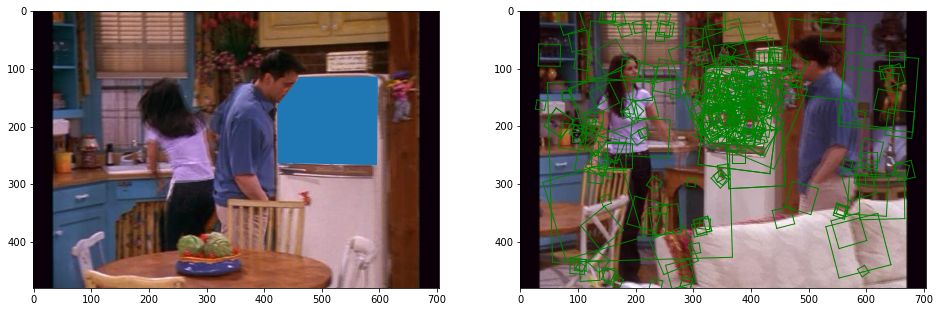

In [3]:
####################################################################
# TODO: Write code to complete the steps described above.          #
####################################################################
mat = scipy.io.loadmat("twoFrameData.mat")
points = np.load("points.npy")
region = np.load("region.npy")

im = mat['im2']
im1 = mat['im1']

desc1 = mat['descriptors1'][points]
desc2 = mat['descriptors2']

indices = match_descriptors(desc1, desc2)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(im1)
polygon = patches.Polygon(region, True)
ax.add_patch(polygon)
bx = fig.add_subplot(122)
bx.imshow(im)

coners = displaySIFTPatches(
    mat['positions2'][indices, :], mat['scales2'][indices, :], mat['orients2'][indices, :]
)
for j in range(len(coners)):
    bx.plot(
        [coners[j][0][1], coners[j][1][1]],
        [coners[j][0][0], coners[j][1][0]],
        color="g",
        linestyle="-",
        linewidth=1,
    )
    bx.plot(
        [coners[j][1][1], coners[j][2][1]],
        [coners[j][1][0], coners[j][2][0]],
        color="g",
        linestyle="-",
        linewidth=1,
    )
    bx.plot(
        [coners[j][2][1], coners[j][3][1]],
        [coners[j][2][0], coners[j][3][0]],
        color="g",
        linestyle="-",
        linewidth=1,
    )
    bx.plot(
        [coners[j][3][1], coners[j][0][1]],
        [coners[j][3][0], coners[j][0][0]],
        color="g",
        linestyle="-",
        linewidth=1,
    )
bx.set_xlim(0, im.shape[1])
bx.set_ylim(0, im.shape[0])
plt.gca().invert_yaxis()
plt.show()


####################################################################
#                        END OF YOUR CODE                          #
####################################################################

### 2.2. Visualizing the vocabulary [20 pts]:

In this part we will build a visual vocabulary.

#### Steps

1. Cluster a large, representative random sample of SIFT descriptors from some portion of the frames using k-means. Let the `k` centers be the visual words. The value of `k` is a free parameter. For this data something like `k = 1500` should work, but feel free to play with this parameter. For clustering, refer to `kmeans` function in **sklearn**. 

   > **Note:** You may run out of memory if you use all the provided SIFT descriptors to build the vocabulary.

   Save the cluster centers to `vocabulary.npy` so that you can use the vocabulary again in other parts of the assignment.


2. Display example image patches associated with any two of the visual words i.e choose raw SIFT descriptors that are nearest to each of the chosen visual words. Choose the two words such that they are distinct to illustrate what the different words are capturing, and display enough patch examples so the word content is evident (e.g., 25 patches per word). 

> Refer to the helper functions `getPatchFromSIFTParameters.py` to display patches and `dist2.py` for fast distance computation.


3. Describe what you see in your answer sheet

#### Deliverables

- [ ] Display patches corresponding with two visual words in your answer sheet.
- [ ] Discuss the results in your answer sheet.

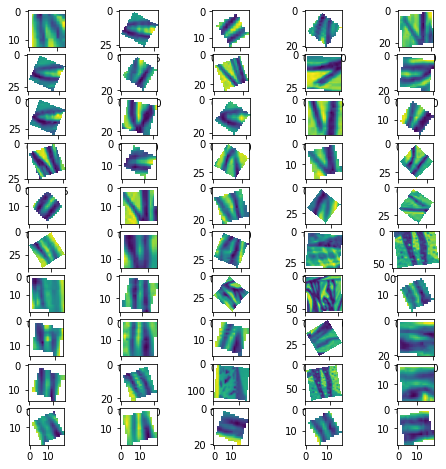

In [76]:
####################################################################
# TODO: Write code to complete the steps described above.          #
####################################################################
siftdir = "sift/"
framesdir = "frames/"
fnames = glob.glob(siftdir + "*.mat")
fnames = [os.path.basename(name) for name in fnames]

"""sample = random.sample(fnames, 500)
inp = scipy.io.loadmat(os.path.join(siftdir, sample[0]))['descriptors']
for i in range(1, len(sample)):
    mat = scipy.io.loadmat(os.path.join(siftdir, sample[i]))['descriptors']
    inp = np.concatenate((inp, mat))

kmeans = MiniBatchKMeans(n_clusters = 1500, batch_size = 32, max_iter = 10).fit(inp)
centers = kmeans.cluster_centers_

np.save("vocabulary.npy", centers)
np.save("sample.npy", sample)"""

vocab = np.load("vocabulary.npy")

word1 = vocab[4].reshape(1, 128)
word2 = vocab[5].reshape(1, 128)
sample = np.load("sample.npy")

q1 = PriorityQueue()
q2 = PriorityQueue()

mat = scipy.io.loadmat(os.path.join(siftdir, sample[0]))
desc = mat['descriptors']
d1 = {}
d2 = {}

for i in range(0, len(sample)):
    mat = scipy.io.loadmat(os.path.join(siftdir, sample[i]))
    desc = mat['descriptors']
    minDistance1 = dist2(word1, desc)
    minDistance1 = minDistance1[0]
    idx1 = np.argpartition(minDistance1, 25)
    minDistance1 = minDistance1[idx1[:25]]
    minDistance2 = dist2(word2, desc)
    minDistance2 = minDistance2[0]
    idx2 = np.argpartition(minDistance2, 25)
    minDistance2 = minDistance2[idx2[:25]]
    for m in range(0, 25):
        d1[minDistance1[m]] = sample[i]
        d2[minDistance2[m]] = sample[i]
        q1.put(minDistance1[m])
        q2.put(minDistance2[m])
        
patches = []
patches2 = []
    
for j in range(0, 25):
    distance1 = q1.get()
    f1 = d1[distance1]
    im1 = imageio.imread(os.path.join(framesdir, f1[:-4]))
    mat1 = scipy.io.loadmat(os.path.join(siftdir, f1))
    patch_num = np.argwhere(dist2(word1, mat1['descriptors']) == distance1)
    img_patch = getPatchFromSIFTParameters(
        mat1["positions"][patch_num[0][1], :],
        mat1["scales"][patch_num[0][1]],
        mat1["orients"][patch_num[0][1]],
        rgb2gray(im1),
    )
    patches.append(img_patch)
    

for k in range(0, 25):
    distance2 = q2.get()
    f2 = d2[distance2]
    im2 = imageio.imread(os.path.join(framesdir, f2[:-4]))
    mat2 = scipy.io.loadmat(os.path.join(siftdir, f2))
    patch_num2 = np.argwhere(dist2(word2, mat2['descriptors']) == distance2)
    img_patch2 = getPatchFromSIFTParameters(
        mat2["positions"][patch_num2[0][1], :],
        mat2["scales"][patch_num2[0][1]],
        mat2["orients"][patch_num2[0][1]],
        rgb2gray(im2),
    )
    patches2.append(img_patch2)

fig = plt.figure()
for a in range(0, 25):
    ax = fig.add_subplot(10, 5, a + 1)
    ax.imshow(patches[a])
for b in range(0, 25):
    ax = fig.add_subplot(10, 5, b + 26)
    ax.imshow(patches2[b])
plt.show()

####################################################################
#                        END OF YOUR CODE                          #
####################################################################

### 2.3.  Full frame queries [20 pts]:

In this part we will use our visual vocabulary to perfom frame queries.

#### Steps

1. Map an image’s features into its bag-of-words histogram. The histogram for image *$I_j$* is a k-dimensional vector:

   $$F(I_j) = [freq_{1,j}, freq_{2,j}, ....., freq_{k,j}]$$

   where each entry *$freq_{i,j}$* counts the number of occurrences of the i-th visual word in that image, and `k` is the number of total words in the vocabulary.
   
   In other words, a single image’s list of `N` **SIFT** descriptors yields a `k-dimensional` bag of words histogram.


2. Compute similarity scores. Compare two bag-of-words histograms using the normalized scalar product:

   $$S(I_i,I_j) = \frac{F(I_i) \cdot F(I_j)}{||F(I_i)||||F(I_j)||} = \frac{1}{||F(I_i)||||F(I_j)||} \sum_{m=1}^{k} freq_{m,i}freq_{m,j}$$

   where $S()$ is the similarity score. $||F(I_i)||$ is the `L2` norm of $F(I_i)$.


3. Sort the similarity scores between a query histogram and the histograms associated with the rest of the images in the video. Pull up the images associated with the `M` most similar examples.


4. After testing your code for bag-of-words visual search, choose 3 diﬀerent frames from the entire video dataset to serve as queries. 


5. Display the `M=5` most similar frames to each of these queries (in rank order) based on the normalized scalar product between their bag of words histograms. 


6. Explain the results in your answer sheet.

#### Deliverables

- [ ] The function `calculate_bag_of_words_histogram` should be included when you export `ps4.py`.
- [ ] The function `caculate_normalized_scalar_product` should be included when you export `ps4.py`.
- [ ] Display `3` different query frames and the `M=5` most similar frames from the video dataset (don't include the query in the results) in your answer sheet.
- [ ] Explain the results in your answer sheet.

In [78]:
def calculate_bag_of_words_histogram(vocabulary, descriptors):
    """ Calculate the bag-of-words histogram for the given frame descriptors.
    
    Inputs:
    - vocabulary: kxd array representing a visual vocabulary
    - descriptors: nxd array of frame descriptors
    
    Outputs:
    - histogram: k-dimensional bag-of-words histogram
    """
    k = vocabulary.shape[0]
    histogram = np.zeros((k,), dtype="int64")

    ############################
    # TODO: Add your code here #
    ############################
    idx = match_descriptors(descriptors, vocabulary)
    for i in range(0, k):
        histogram[i] = np.count_nonzero(idx == i)
        
    ############################
    #     END OF YOUR CODE     #
    ############################

    return histogram

In [79]:
def caculate_normalized_scalar_product(hist1, hist2):
    """ Caculate the normalized scalar product between two histograms.
    
    Inputs:
    - hist1: k-dimensional array
    - hist2: k-dimensional array
    
    Outputs:
    - score: the normalized scalar product described above
    """
    score = 0
    
    ############################
    # TODO: Add your code here #
    ############################
    mag1 = np.linalg.norm(hist1)
    mag2 = np.linalg.norm(hist2)
    if mag1 == 0:
        mag1 = 0.0000000001
    if mag2 == 0:
        mag2 = 0.0000000001
    score = np.dot(hist1, hist2) / (mag1 * mag2)    
    ############################
    #     END OF YOUR CODE     #
    ############################
    
    return score

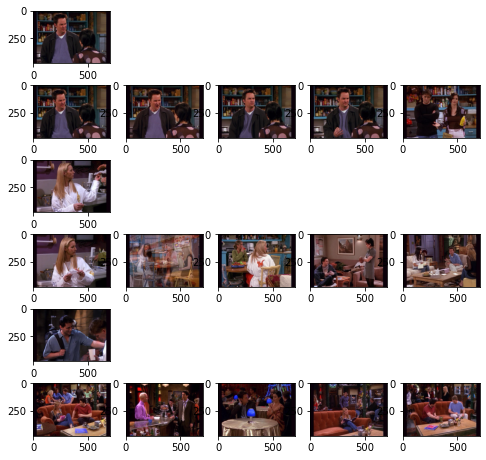

In [80]:
####################################################################
# TODO: Write code to complete the steps described above. Make     #
# sure you use your `calculate_bag_of_words_histogram` and         #
# `caculate_normalized_scalar_product` functions.                  #
####################################################################
siftdir = "sift/"
framesdir = "frames/"
fnames = glob.glob(siftdir + "*.mat")
fnames = [os.path.basename(name) for name in fnames]
vocab = np.load("vocabulary.npy")

fname1 = fnames[15]
fname2 = fnames[fnames.index(fname1) + 10]
fname3 = fnames[fnames.index(fname1) + 20]

img1 = imageio.imread(os.path.join(framesdir, fname1[:-4]))
img2 = imageio.imread(os.path.join(framesdir, fname2[:-4]))
img3 = imageio.imread(os.path.join(framesdir, fname3[:-4]))

desc1 = scipy.io.loadmat(os.path.join(siftdir, fname1))['descriptors']
desc2 = scipy.io.loadmat(os.path.join(siftdir, fname2))['descriptors']
desc3 = scipy.io.loadmat(os.path.join(siftdir, fname3))['descriptors']

queryHist1 = calculate_bag_of_words_histogram(vocab, desc1)
queryHist2 = calculate_bag_of_words_histogram(vocab, desc2)
queryHist3 = calculate_bag_of_words_histogram(vocab, desc3)
dict1 = {}
dict2 = {}
dict3 = {}
scores1 = PriorityQueue()
scores2 = PriorityQueue()
scores3 = PriorityQueue()


for i in range(0, len(fnames)):
    desc = scipy.io.loadmat(os.path.join(siftdir, fnames[i]))['descriptors']
    hist = calculate_bag_of_words_histogram(vocab, desc)
    score1 = caculate_normalized_scalar_product(queryHist1, hist)
    score2 = caculate_normalized_scalar_product(queryHist2, hist)
    score3 = caculate_normalized_scalar_product(queryHist3, hist)
    
    if (fnames[i] != fname1):
        scores1.put(-score1)
        dict1[score1] = fnames[i]
    if (fnames[i] != fname2):
        scores2.put(-score2)
        dict2[score2] = fnames[i]
    if (fnames[i] != fname3):
        scores3.put(-score3)
        dict3[score3] = fnames[i]
    

fig = plt.figure()
ax = fig.add_subplot(6, 5, 1)
ax.imshow(img1)
ax = fig.add_subplot(6, 5, 11)
ax.imshow(img2)
ax = fig.add_subplot(6, 5, 21)
ax.imshow(img3)
for j in range(0, 5):
    s1 = -scores1.get()
    s2 = -scores2.get()
    s3 = -scores3.get()
    
    f1 = dict1[s1]
    f2 = dict2[s2]
    f3 = dict3[s3]
    
    im1 = imageio.imread(os.path.join(framesdir, f1[:-4]))
    im2 = imageio.imread(os.path.join(framesdir, f2[:-4]))
    im3 = imageio.imread(os.path.join(framesdir, f3[:-4]))
    
    ax = fig.add_subplot(6, 5, 6 + j)
    ax.imshow(im1)
    ax = fig.add_subplot(6, 5, 16 + j)
    ax.imshow(im2)
    ax = fig.add_subplot(6, 5, 26 + j)
    ax.imshow(im3)

plt.show()
####################################################################
#                        END OF YOUR CODE                          #
####################################################################

### 2.4.  Region queries [20 pts]:

In this step we will use regions of interest within an image to query frames from the video.

#### Steps

1. Form a query from a region within a frame. Select a polygonal region interactively with the mouse, and compute a bag of words histogram from only the SIFT descriptors that fall within that region.  Optionally, you may weight it with tf-idf.

   > You may want to reuse your `select_roi.py` script here.


2. Select your favorite query regions from within 4 frames (which may be diﬀerent than those used above) to demonstrate the retrieved frames when only a portion of the SIFT descriptors are used to form a bag of words. 

   > Try to include example(s) where the same object is found in the **most similar M frames** but amidst diﬀerent objects or backgrounds, and also **include a failure case**. 

3. Explain the results, including possible reasons for the failure cases in your answer sheet.

#### Deliverables

- [ ] Display the selected query region and the `M=5` most similar frames for `4` different queries in your answer sheet.
- [ ] Explain the results in your answer sheet.

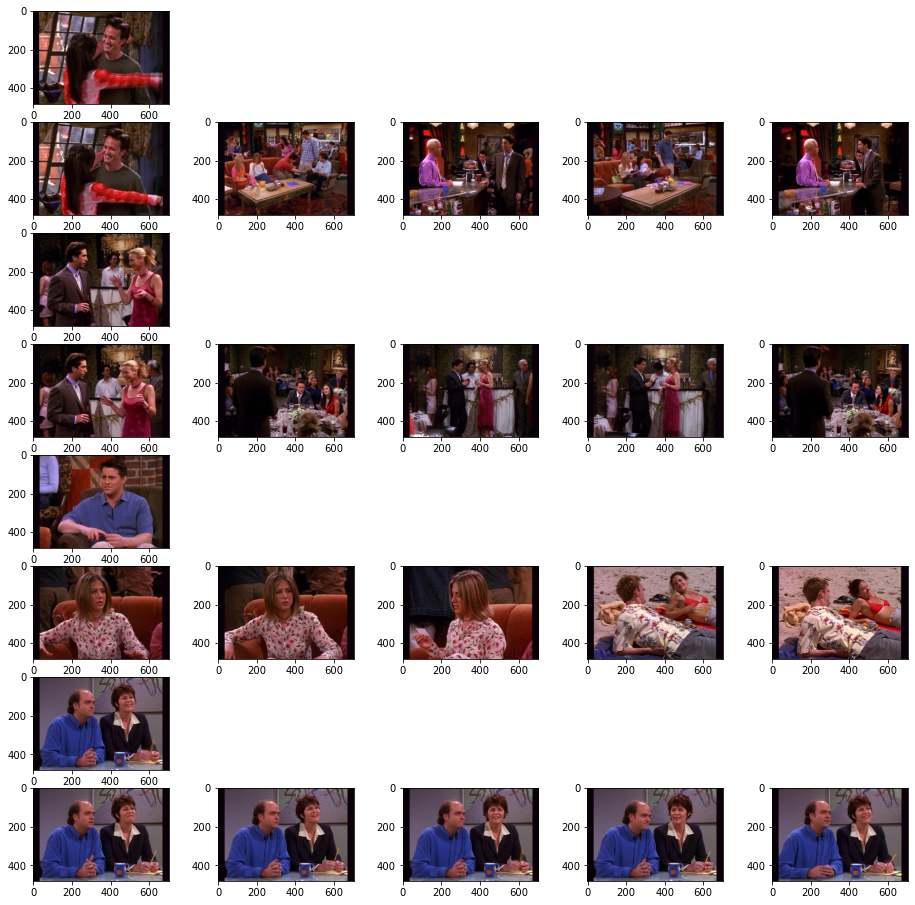

In [84]:
####################################################################
# TODO: Write code to complete the steps described above.          #
####################################################################
framesdir = "frames/"
siftdir = "sift/"
vocab = np.load("vocabulary.npy")

fnames = glob.glob(siftdir + "*.mat")
fnames = [os.path.basename(name) for name in fnames]

fname1 = fnames[100]
fname2 = fnames[200]
fname3 = fnames[350]
fname4 = fnames[450]

img1 = imageio.imread(os.path.join(framesdir, fnames[100][:-4]))
img2 = imageio.imread(os.path.join(framesdir, fnames[200][:-4]))
img3 = imageio.imread(os.path.join(framesdir, fnames[350][:-4]))
img4 = imageio.imread(os.path.join(framesdir, fnames[450][:-4]))

points1 = np.load("points1.npy")
points2 = np.load("points2.npy")
points3 = np.load("points3.npy")
points4 = np.load("points4.npy")

desc1 = scipy.io.loadmat(os.path.join(siftdir, fname1))['descriptors'][points1]
desc2 = scipy.io.loadmat(os.path.join(siftdir, fname2))['descriptors'][points2]
desc3 = scipy.io.loadmat(os.path.join(siftdir, fname3))['descriptors'][points3]
desc4 = scipy.io.loadmat(os.path.join(siftdir, fname4))['descriptors'][points4]

queryHist1 = calculate_bag_of_words_histogram(vocab, desc1)
queryHist2 = calculate_bag_of_words_histogram(vocab, desc2)
queryHist3 = calculate_bag_of_words_histogram(vocab, desc3)
queryHist4 = calculate_bag_of_words_histogram(vocab, desc4)
dict1 = {}
dict2 = {}
dict3 = {}
dict4 = {}
scores1 = PriorityQueue()
scores2 = PriorityQueue()
scores3 = PriorityQueue()
scores4 = PriorityQueue()


for i in range(0, len(fnames)):
    desc = scipy.io.loadmat(os.path.join(siftdir, fnames[i]))['descriptors']
    hist = calculate_bag_of_words_histogram(vocab, desc)
    score1 = caculate_normalized_scalar_product(queryHist1, hist)
    score2 = caculate_normalized_scalar_product(queryHist2, hist)
    score3 = caculate_normalized_scalar_product(queryHist3, hist)
    score4 = caculate_normalized_scalar_product(queryHist4, hist)
    
    if (fnames[i] != fname1):
        scores1.put(-score1)
        dict1[score1] = fnames[i]
    if (fnames[i] != fname2):
        scores2.put(-score2)
        dict2[score2] = fnames[i]
    if (fnames[i] != fname3):
        scores3.put(-score3)
        dict3[score3] = fnames[i]
    if (fnames[i] != fname4):
        scores4.put(-score4)
        dict4[score4] = fnames[i]
    

fig = plt.figure()
ax = fig.add_subplot(8, 5, 1)
ax.imshow(img1)
ax = fig.add_subplot(8, 5, 11)
ax.imshow(img2)
ax = fig.add_subplot(8, 5, 21)
ax.imshow(img3)
ax = fig.add_subplot(8, 5, 31)
ax.imshow(img4)
for j in range(0, 5):
    s1 = -scores1.get()
    s2 = -scores2.get()
    s3 = -scores3.get()
    s4 = -scores4.get()
    
    f1 = dict1[s1]
    f2 = dict2[s2]
    f3 = dict3[s3]
    f4 = dict4[s4]
    
    im1 = imageio.imread(os.path.join(framesdir, f1[:-4]))
    im2 = imageio.imread(os.path.join(framesdir, f2[:-4]))
    im3 = imageio.imread(os.path.join(framesdir, f3[:-4]))
    im4 = imageio.imread(os.path.join(framesdir, f4[:-4]))
    
    ax = fig.add_subplot(8, 5, 6 + j)
    ax.imshow(im1)
    ax = fig.add_subplot(8, 5, 16 + j)
    ax.imshow(im2)
    ax = fig.add_subplot(8, 5, 26 + j)
    ax.imshow(im3)
    ax = fig.add_subplot(8, 5, 36 + j)
    ax.imshow(im4)

plt.show()
####################################################################
#                        END OF YOUR CODE                          #
####################################################################